In [1]:
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms as T

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

%cd ../
from src.data.datasets import HandwritingDataset
from src.models.models import HandwritingClassifier
%cd notebooks/

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/nazar/Projects/ukrainian_handwriting
/home/nazar/Projects/ukrainian_handwriting/notebooks


In [2]:
device = torch.device('cuda:0')

# Loading train/test/val

In [3]:
MEAN = HandwritingClassifier._mean
STD = HandwritingClassifier._std

In [4]:
tf = T.Compose([
    T.RandomRotation(30),
    T.RandomAffine(0, (0.1, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD)
])

In [5]:
train_data = HandwritingDataset(
    '../data/processed/train_data.csv',
    transforms=tf
)

test_data = HandwritingDataset(
    '../data/processed/test_data.csv',
    transforms=T.Compose([
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
)

print('Number of samples in training data:', len(train_data))
print('Number of samples in test data:', len(test_data))

Number of samples in training data: 1281
Number of samples in test data: 300


In [6]:
BATCH_SIZE = 64
VAL_SIZE = 100

indices = list(range(len(train_data)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[VAL_SIZE:], indices[:VAL_SIZE]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_data, BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(train_data, sampler=val_sampler)
test_loader = DataLoader(test_data)

# Functions for training

In [7]:
def compute_accuracy(prediction, ground_truth):
    correct = torch.sum(prediction == ground_truth).item()
    return correct / len(ground_truth)


def validate(model, losses, loader):
    model.eval()
    lbl_acc = 0
    is_upp_acc = 0
    loss_acum = 0
    for i, (x, *y) in enumerate(loader):
        x_gpu = x.to(device)
        y[1] = y[1].unsqueeze(1).float()
        y_gpu = tuple(targ.to(device) for targ in y)
        
        prediction = model(x_gpu)
        loss_value = sum(
            loss(out, targ) for loss, out, targ in zip(losses, prediction, y_gpu)
        )
        
        loss_acum += loss_value.item()
        lbl = torch.argmax(prediction[0], 1)
        lbl_acc += compute_accuracy(lbl, y_gpu[0])
        is_upp = 0 if prediction[1].item() < 0.5 else 1
        is_upp_acc += compute_accuracy(is_upp, y_gpu[1])
    return loss_acum / i, lbl_acc / i, is_upp_acc / i  


def train_model(model, train_loader, val_loader, optimizer, losses, num_epochs, scheduler=None):
    t_loss_history = []
    v_loss_history = []
    lbl_acc_history = []
    is_upp_acc_hist = []
    
    for epoch in range(num_epochs):
        model.train()
        
        loss_acum = 0
        for i, (x, *y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y[1] = y[1].unsqueeze(1).float()
            y_gpu = tuple(target.to(device) for target in y)
            
            prediction = model(x_gpu)
            loss_value = sum(
                loss(out, targ) for loss, out, targ in zip(losses, prediction, y_gpu)
            )
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            loss_acum += loss_value.item()
        epoch_loss = loss_acum / i
        val_loss, lbl_acc, is_upp_acc = validate(model, losses, val_loader)
        
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        t_loss_history.append(epoch_loss)
        v_loss_history.append(val_loss)
        lbl_acc_history.append(lbl_acc)
        is_upp_acc_hist.append(is_upp_acc)
        
        print(f'{epoch + 1}. Loss = {epoch_loss:.6f}; Val loss = {val_loss:.6f}')
        print(f'Label accuracy = {lbl_acc}; Is_upper accuracy = {is_upp_acc}')
    return t_loss_history, v_loss_history, lbl_acc_history, is_upp_acc_hist 


def evaluate(model, loader):
    model.eval()
    lbl_acc = 0
    is_upp_acc = 0
    lbl_preds = []
    lbl_gt = []
    is_upp_preds = []
    is_upp_gt = []
    for i, (x, *y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = tuple(target.to(device) for target in y)
        
        prediction = model(x_gpu)
        lbl = torch.argmax(prediction[0], 1)
        is_upp = 0 if prediction[1].item() < 0.5 else 1
        
        lbl_preds.append(lbl.item())
        lbl_gt.append(y_gpu[0].item())
        is_upp_preds.append(is_upp)
        is_upp_gt.append(y_gpu[1].item())
        
        lbl_acc += compute_accuracy(lbl, y_gpu[0])
        is_upp_acc += compute_accuracy(is_upp, y_gpu[1])
    accuracy = (lbl_acc / i, is_upp_acc/ i)
    predictions = (lbl_preds, is_upp_preds)
    ground_truth = (lbl_gt, is_upp_gt)
    return accuracy, predictions, ground_truth
        

def plot_history(t_loss_h, v_loss_h, lbl_acc_h, is_upp_acc_h):
    fig, ax = plt.subplots(2, 1, figsize=(15, 7))
    ax[0].set_title('Train/validation Loss')
    ax[0].plot(t_loss_h, label='Train')
    ax[0].plot(v_loss_h, label='Validation')
    ax[0].legend()
    ax[1].set_title('Accuracy for 2 outputs')
    ax[1].plot(lbl_acc_h, label='Label')
    ax[1].plot(is_upp_acc_h, label='Is uppercase')
    ax[1].legend();

# Model training

In [8]:
model = HandwritingClassifier()
model.load_state_dict(torch.load('../models/mnist_model.pt'), strict=False)


with open('../models/best_params.json', 'r') as f:
    params = json.load(f)

LR = params['learning_rate']
NUM_EPOCHS = params['num_epochs']
REG = params['weight_decay']
GAMMA = params['factor']
PAT = params['patience']

model.type(torch.cuda.FloatTensor)
model.to(device)

criterion_1 = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
criterion_2 = nn.BCEWithLogitsLoss().type(torch.cuda.FloatTensor)
losses = (criterion_1, criterion_2)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=REG)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=GAMMA, patience=PAT)

In [9]:
train_loss, val_loss, lbl_acc, is_upp_acc = train_model(model, train_loader, val_loader, optimizer, losses,
                                                        NUM_EPOCHS, scheduler)

1. Loss = 4.368683; Val loss = 3.790481
Label accuracy = 0.31313131313131315; Is_upper accuracy = 0.7373737373737373
2. Loss = 3.404053; Val loss = 2.917786
Label accuracy = 0.41414141414141414; Is_upper accuracy = 0.8080808080808081
3. Loss = 2.830087; Val loss = 2.611367
Label accuracy = 0.40404040404040403; Is_upper accuracy = 0.8888888888888888
4. Loss = 2.481314; Val loss = 2.415925
Label accuracy = 0.4444444444444444; Is_upper accuracy = 0.8484848484848485
5. Loss = 2.245533; Val loss = 2.086992
Label accuracy = 0.494949494949495; Is_upper accuracy = 0.9191919191919192
6. Loss = 2.007985; Val loss = 2.017802
Label accuracy = 0.5454545454545454; Is_upper accuracy = 0.8686868686868687
7. Loss = 1.827143; Val loss = 1.899867
Label accuracy = 0.6060606060606061; Is_upper accuracy = 0.9090909090909091
8. Loss = 1.687237; Val loss = 1.793408
Label accuracy = 0.5252525252525253; Is_upper accuracy = 0.9191919191919192
9. Loss = 1.604887; Val loss = 1.667148
Label accuracy = 0.62626262626

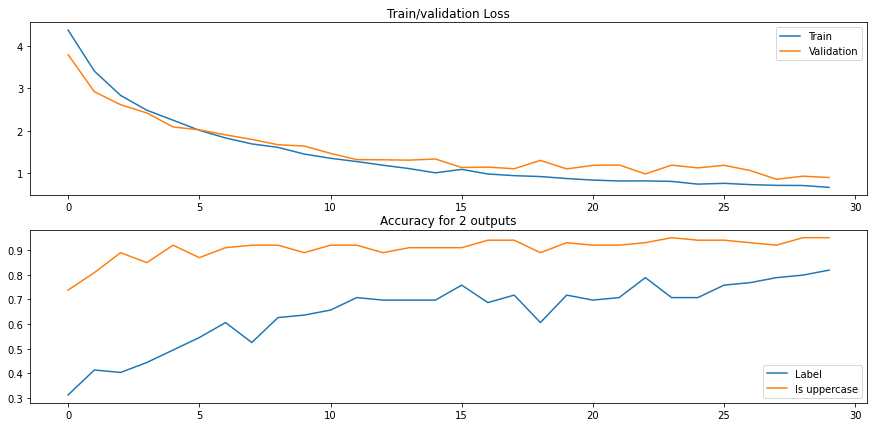

In [10]:
plot_history(train_loss, val_loss, lbl_acc, is_upp_acc)

## Model evaluation

In [11]:
test_acc, preds, gt = evaluate(model, test_loader)

In [12]:
print(f'Token accuracy on test dataset: {test_acc[0]:.2%} ({test_acc[0]})')
print(f'Uppercase accuracy on test dataset: {test_acc[1]:.2%} ({test_acc[1]})')

Token accuracy on test dataset: 91.64% (0.9163879598662207)
Uppercase accuracy on test dataset: 95.65% (0.9565217391304348)


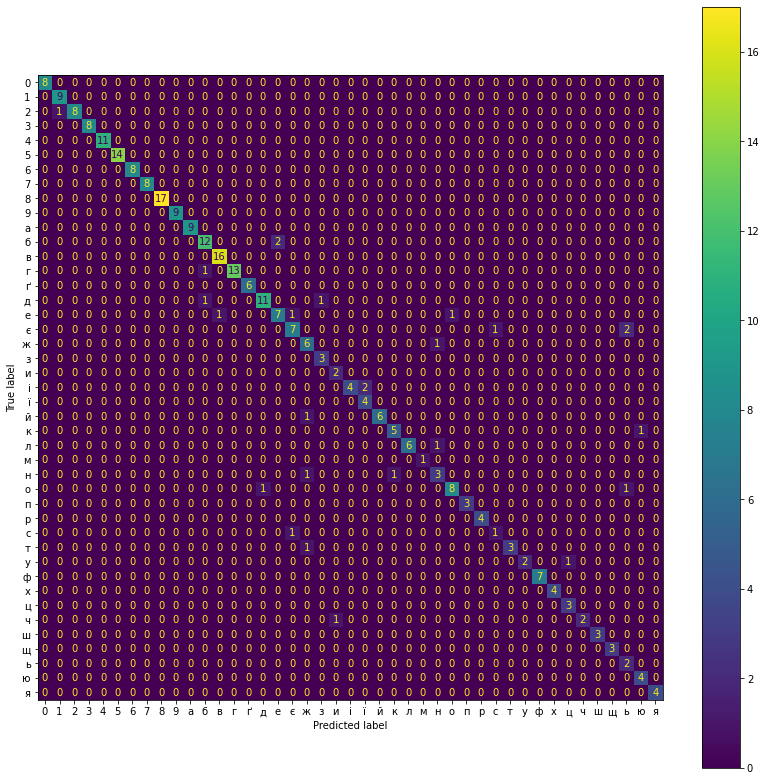

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
labels = list('0123456789абвгґдеєжзиіїйклмнопрстуфхцчшщьюя')
ConfusionMatrixDisplay.from_predictions(gt[0], preds[0], display_labels=labels, ax=ax);

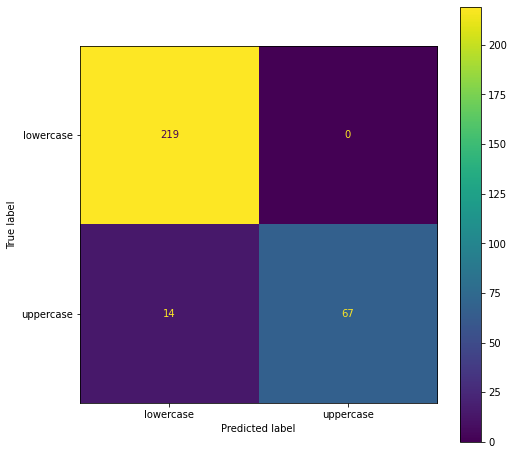

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
labels = ['lowercase', 'uppercase']
ConfusionMatrixDisplay.from_predictions(gt[1], preds[1], display_labels=labels, ax=ax);

In [15]:
# save model
torch.save(model.state_dict(), '../models/complete_model.pt')